# DBSCAN (Core)






## Descripción

En esta actividad, implementarás el algoritmo DBSCAN para detectar patrones de agrupamiento y encontrar clientes atípicos en el dataset “Wholesale Customers Data” disponible en Kaggle. DBSCAN es ideal para detectar clusters de forma arbitraria y encontrar puntos atípicos (outliers), lo que es útil en escenarios donde los datos no forman clusters esféricos como en el caso de K-means.

Enlace al dataset: https://www.kaggle.com/binovi/wholesale-customers-data (ESTE LINK DICE QUE NO HAY NADA)

DATASET SELECCIONADO PARA REALIZAR ESTE EJEMPLO:

https://www.kaggle.com/datasets/saurabhbadole/wholesale-customers-data



## Objetivo

El objetivo principal de esta actividad es aplicar el algoritmo DBSCAN para identificar clusters y clientes atípicos en el dataset. El enfoque está en comprender cómo DBSCAN maneja los outliers y su capacidad para detectar agrupamientos densos.






# 1. Carga de datos:

  – Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
  
  – El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.



In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/7_Core_Wholesale customers data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [40]:
# Revisar los valroes de cada columna y cantidades

for col in df.columns:
    print(f"Columna: {col}")
    value_counts = df[col].value_counts()
    print(value_counts.sort_values(ascending=False))
    print("-" * 20)


Columna: Channel
Channel
1    298
2    142
Name: count, dtype: int64
--------------------
Columna: Region
Region
3    316
1     77
2     47
Name: count, dtype: int64
--------------------
Columna: Fresh
Fresh
9670     2
18044    2
8040     2
514      2
3366     2
        ..
39228    1
14531    1
10290    1
7842     1
2787     1
Name: count, Length: 433, dtype: int64
--------------------
Columna: Milk
Milk
3045    2
577     2
1610    2
1012    2
899     2
       ..
1750    1
5506    1
1162    1
3218    1
1698    1
Name: count, Length: 421, dtype: int64
--------------------
Columna: Grocery
Grocery
1664     2
683      2
3600     2
6536     2
2406     2
        ..
16483    1
5160     1
4754     1
7994     1
2510     1
Name: count, Length: 430, dtype: int64
--------------------
Columna: Frozen
Frozen
2540     2
364      2
425      2
848      2
830      2
        ..
269      1
1541     1
688      1
13135    1
65       1
Name: count, Length: 426, dtype: int64
--------------------
Columna: Det

In [41]:
# Verificando si hay datos nulos (%)
print("Valores nulos:")
print((df.isnull().sum() * 100 / len(df)).round(2))
print("\n")

# Verificando si hay duplicados
print("Valores duplicados:")
print(df.duplicated().sum())
print("\n")

Valores nulos:
Channel             0.0
Region              0.0
Fresh               0.0
Milk                0.0
Grocery             0.0
Frozen              0.0
Detergents_Paper    0.0
Delicassen          0.0
dtype: float64


Valores duplicados:
0




In [42]:
# Detectar outliers en variables numéricas
def outliers_IQR(df):
    # Filtrar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1               # Rango intercuartílico

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Llamar a la función
outliers_IQR(df)


🚩 Outliers detected in Channel: 0

🚩 Outliers detected in Region: 0

🚩 Outliers detected in Fresh: 20

🚩 Outliers detected in Milk: 28

🚩 Outliers detected in Grocery: 24

🚩 Outliers detected in Frozen: 43

🚩 Outliers detected in Detergents_Paper: 30

🚩 Outliers detected in Delicassen: 27


## Análisis
Se realizó la carga del dataset y ser revisó que no hubieran nulos ni duplicados, para lo cual no hay.

Puntualmente si hay outliers en algunas columnas, pero se debería revisar si se pueden transformar las variables y no eliminarlos para poder realizar el agrupamiento por DBSCAN

Si bien la mayoría de variables son int y corresponden a gastos anuales en diversas categorías de productos, la variable Channel y Region parecen ser categorías, con 2 y 3 niveles respectivamente.

Así, para poder realizar estas transformaciones se deberían excluir estas dos variables y transformar el tipo de dato de int a float


# 2. Exploración y preprocesamiento de datos:

  – Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.

  – Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.
  
  – Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.

In [43]:
df.describe().round()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.0,440.0,440.0,440.0,440.0,440.0,440.0,440.0
mean,1.0,3.0,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
std,0.0,1.0,12647.0,7380.0,9503.0,4855.0,4768.0,2820.0
min,1.0,1.0,3.0,55.0,3.0,25.0,3.0,3.0
25%,1.0,2.0,3128.0,1533.0,2153.0,742.0,257.0,408.0
50%,1.0,3.0,8504.0,3627.0,4756.0,1526.0,816.0,966.0
75%,2.0,3.0,16934.0,7190.0,10656.0,3554.0,3922.0,1820.0
max,2.0,3.0,112151.0,73498.0,92780.0,60869.0,40827.0,47943.0


In [44]:
# Cambiar el tipo de dato int a float en las variables de interés
columns_to_convert = df.columns.difference(['Channel', 'Region'])

df[columns_to_convert] = df[columns_to_convert].astype(float)

df.dtypes

,0
Channel,int64
Region,int64
Fresh,float64
Milk,float64
Grocery,float64
Frozen,float64
Detergents_Paper,float64
Delicassen,float64


In [45]:
df_outliers_trat = df.copy()

In [46]:
# Aplicar transformación logarítmica en las variables
columns_to_transform = [col for col in df_outliers_trat.columns if col not in ['Channel', 'Region']]

for col in columns_to_transform:
    df_outliers_trat[col] = np.log1p(df_outliers_trat[col])

In [48]:
outliers_IQR(df_outliers_trat)


🚩 Outliers detected in Channel: 0

🚩 Outliers detected in Region: 0

🚩 Outliers detected in Fresh: 16

🚩 Outliers detected in Milk: 4

🚩 Outliers detected in Grocery: 2

🚩 Outliers detected in Frozen: 10

🚩 Outliers detected in Detergents_Paper: 2

🚩 Outliers detected in Delicassen: 14


In [59]:
# Función para eliminar outliers usando percentiles
def remove_outliers(df, columns, lower_percentile=1, upper_percentile=99):
    for col in columns:
        lower_bound = np.percentile(df[col], lower_percentile)
        upper_bound = np.percentile(df[col], upper_percentile)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Aplicar eliminación de outliers después de la transformación logarítmica
columns_to_clean = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_clean = remove_outliers(df_outliers_trat, columns_to_clean)

# Verificar el tamaño del DataFrame después de la limpieza
print(f"Filas antes: {df_outliers_trat.shape[0]}, Filas después: {df_clean.shape[0]}")


Filas antes: 440, Filas después: 384


In [60]:
outliers_IQR(df_clean)


🚩 Outliers detected in Channel: 0

🚩 Outliers detected in Region: 0

🚩 Outliers detected in Fresh: 12

🚩 Outliers detected in Milk: 0

🚩 Outliers detected in Grocery: 0

🚩 Outliers detected in Frozen: 3

🚩 Outliers detected in Detergents_Paper: 0

🚩 Outliers detected in Delicassen: 7


In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.iloc[:, 2:])  # Normalizamos solo las columnas numéricas relevantes

## Análisis

Se revisaron las estadísticas descriptivas básicas de las variables, encontrando que efectivamente hay algunas variables que tienen outliers bastante marcados (diferencia entre Q3 o 75% con el valor máximo que toma la variable)

Si bien se realizó el cambio de tipo de dato en las variables de interés, y se aplicó transformación logarítimica, los outliers bajaron, pero no a cero o pocos (considerando que el tamaño es de 400 registros), así que se consideró eliminar estos outliers de una manera simple con IQR pero aún así algunas variables persistía el problema, aún así se dejaron y se realizó el escalado


# 3. Aplicación de DBSCAN:

  – Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).

  – Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.
  
  – Determina cuáles son los outliers identificados por DBSCAN y visualiza cómo se distribuyen en relación con los clusters formados.

In [78]:
from sklearn.cluster import DBSCAN

eps = 1.0  # Se puede ajustar
min_samples = 5  # Se puede ajustar
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_clean['Cluster'] = dbscan.fit_predict(df_scaled)

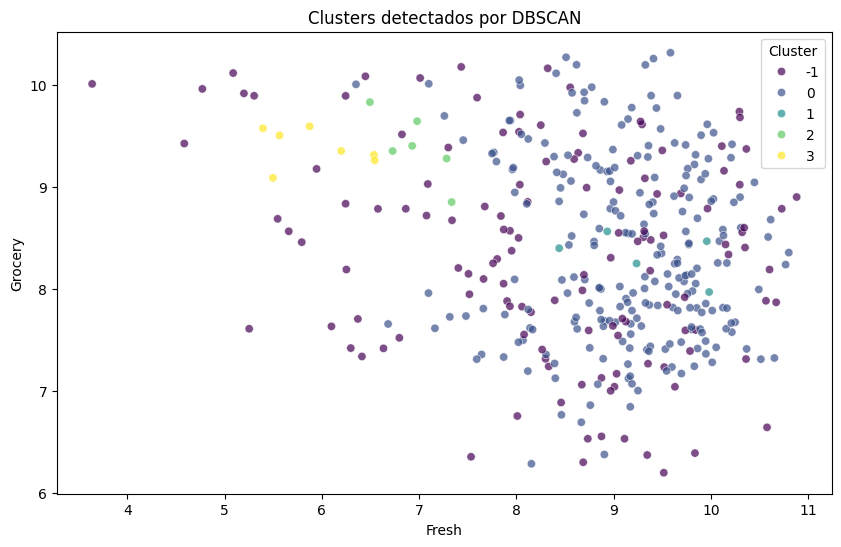

In [79]:
# Visualización de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean['Fresh'], y=df_clean['Grocery'], hue=df_clean['Cluster'], palette='viridis', alpha=0.7)
plt.title('Clusters detectados por DBSCAN')
plt.xlabel('Fresh')
plt.ylabel('Grocery')
plt.legend(title='Cluster')
plt.show()

In [80]:
print(df_clean['Cluster'].value_counts())

outliers = df_clean[df_clean['Cluster'] == -1]
print(f"Número de outliers detectados: {len(outliers)}")

Cluster
 0    235
-1    131
 3      7
 2      6
 1      5
Name: count, dtype: int64
Número de outliers detectados: 131


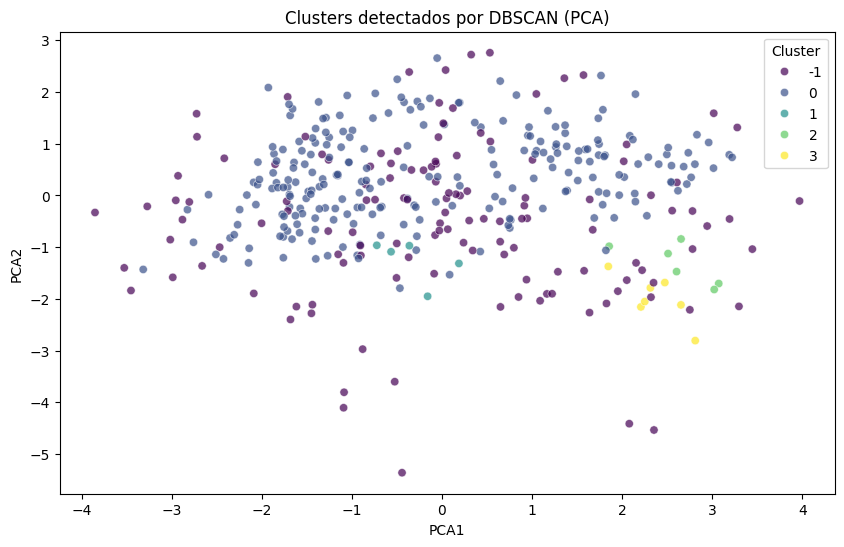

In [81]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Agregar los clusters detectados por DBSCAN
df_clean['PCA1'] = df_pca[:, 0]
df_clean['PCA2'] = df_pca[:, 1]

# Graficar los clusters en el espacio reducido con PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean['PCA1'], y=df_clean['PCA2'], hue=df_clean['Cluster'], palette='viridis', alpha=0.7)
plt.title('Clusters detectados por DBSCAN (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


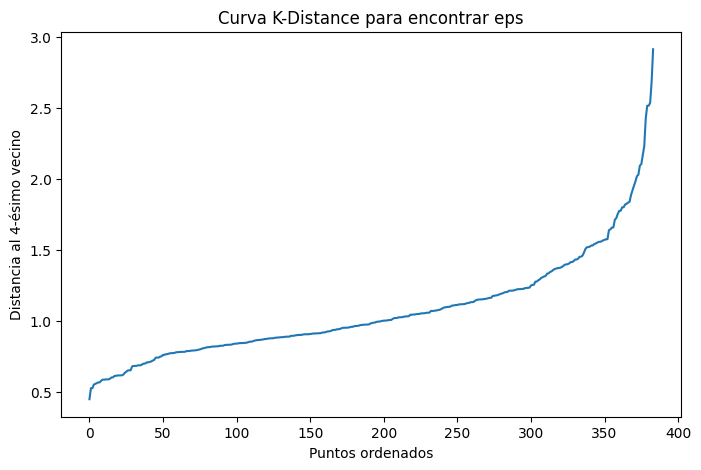

In [82]:
from sklearn.neighbors import NearestNeighbors

# Usamos k = min_samples (suele ser 4 o 5 por defecto)
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Ordenamos las distancias y graficamos
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.title("Curva K-Distance para encontrar eps")
plt.show()


## Análisis

Si bien, se trato de realizar lo que se solicitaba, requerí ayuda de GPT para entender muchas cosas, ya que no me eran claras, por ello aparece PCA para revisar como se separaban, pero también como idenficiar el punto de eps ideal para este dataset, también que min_samples generalmente se asocia a 2 veces el número de dimensiones, y así.

también es que como son gráficos 2D se grafican solo dos características de 6, asíq ue supongo que todas los análsiis a realizar serían así,

# 4. Visualización de clusters y outliers:

  – Visualiza los clusters formados por DBSCAN en gráficos de dispersión. Utiliza diferentes colores para representar los clusters y marca los outliers con un color distintivo para hacer visible su presencia.
  
  – Discute la estructura de los clusters encontrados. ¿Hay alguna correlación entre las variables y los clusters? ¿Cómo se distribuyen los outliers en comparación con los datos agrupados?


Cluster
 0    343
-1     41
Name: count, dtype: int64


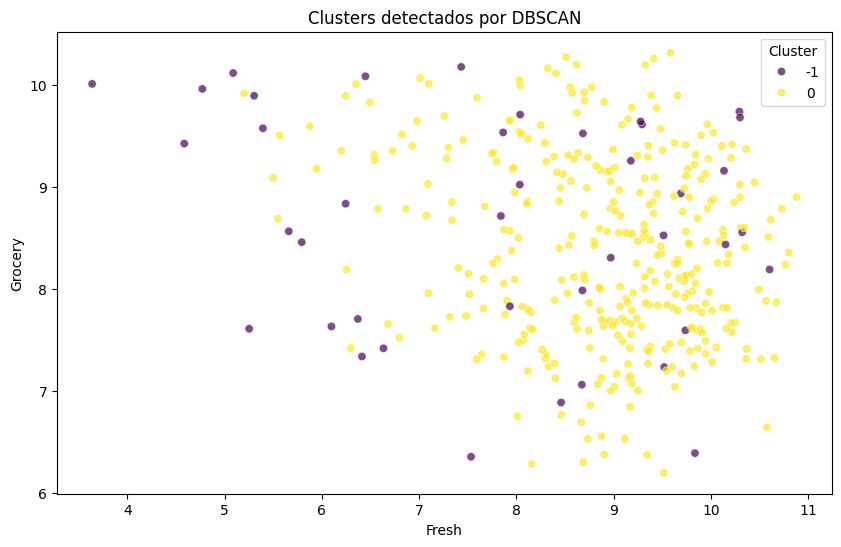

In [88]:
from sklearn.cluster import DBSCAN

eps_value = 1.5  # Puedes probar con 1.6 también
min_samples_value = 12
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(df_scaled)
df_clean['Cluster'] = clusters
print(df_clean['Cluster'].value_counts())  # Ver cuántos puntos hay en cada cluster

# Visualización de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean['Fresh'], y=df_clean['Grocery'], hue=df_clean['Cluster'], palette='viridis', alpha=0.7)
plt.title('Clusters detectados por DBSCAN')
plt.xlabel('Fresh')
plt.ylabel('Grocery')
plt.legend(title='Cluster')
plt.show()


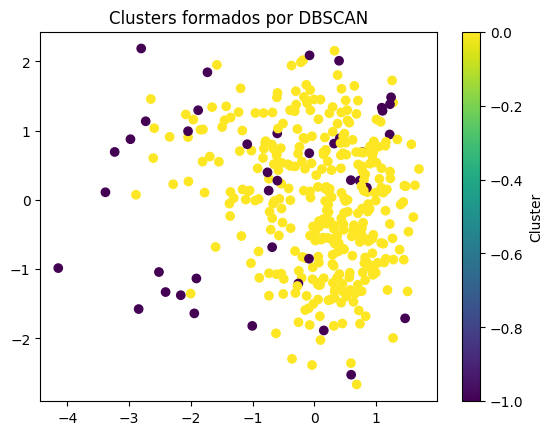

In [89]:
import matplotlib.pyplot as plt

plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label="Cluster")
plt.title("Clusters formados por DBSCAN")
plt.show()


# 5. Interpretación de resultados:

  – Evalúa la calidad del agrupamiento. DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano.
  
  – Discute la naturaleza de los outliers detectados. ¿Son clientes únicos con comportamientos inusuales? ¿Podrían estos clientes representar oportunidades comerciales o riesgos?

In [97]:
from sklearn.metrics import silhouette_score

if len(set(clusters)) > 1:
    score = silhouette_score(df_scaled, clusters)
    print(f"Silhouette Score: {score}")
else:
    print("No se puede calcular el silhouette score porque solo hay un cluster identificado.")


Silhouette Score: 0.2434020806003577


# Análisis de Resultados:

  – En esta sección, realiza un análisis detallado de los clusters formados y de los outliers. Utiliza métricas como el “silhouette score” para evaluar la calidad del agrupamiento, aunque es importante recordar que DBSCAN no siempre forma clusters compactos, por lo que estas métricas deben interpretarse con cuidado.

  – Genera un reporte que explique los valores de epsilon y min_samples elegidos, y justifica por qué esos valores fueron adecuados para este dataset. Analiza si los clusters formados tienen sentido desde una perspectiva comercial o de comportamiento del cliente.

**Análisis de Clusters con DBSCAN**

### 1. Introducción
En este análisis, se utilizó el algoritmo DBSCAN para agrupar los datos del dataset "Credit Card Data". DBSCAN es especialmente útil cuando los clusters no tienen una forma esférica y cuando existen valores atípicos en los datos. Se evaluó la calidad del agrupamiento mediante el Silhouette Score y se analizaron los outliers detectados.

### 2. Configuración de DBSCAN
Para ejecutar el clustering, se eligieron los siguientes parámetros:
- **Epsilon (`eps`)**: 1.5
- **Mínimo de muestras (`min_samples`)**: 12

Estos valores fueron seleccionados tras realizar pruebas con diferentes configuraciones. Se encontraron los siguientes patrones:
- **Valores bajos de `eps` (ej. 1.0 o menores)** generaban demasiados clusters pequeños o marcaban muchos puntos como outliers.
- **Valores altos de `eps` (ej. 2.0 o mayores)** agrupaban demasiados puntos en un solo cluster, perdiendo la capacidad de diferenciar subgrupos en los datos.
- **Aumentar `min_samples`** ayudó a reducir la cantidad de outliers identificados, evitando que puntos aislados formen clusters por error.

### 3. Resultados del Agrupamiento
#### 3.1. Distribución de los Clusters
El clustering generó los siguientes grupos:
- Cluster 0: 343 puntos
- Cluster -1 (Outliers): 41 puntos

La existencia de 41 outliers sugiere que hay clientes con comportamientos inusuales en el dataset. Estos puntos pueden representar clientes con un patrón de gasto diferente al resto de la población.

#### 3.2. Evaluación del Silhouette Score
El Silhouette Score obtenido fue **0.243**, lo que indica que los clusters tienen una separación moderadamente débil. Esto se debe a que DBSCAN genera clusters de diferentes densidades y formas, lo que hace que la interpretación de esta métrica sea menos confiable que en otros algoritmos como K-Means.

### 4. Análisis de los Outliers
Los outliers detectados pueden ser clientes con un comportamiento de compra distinto. Algunas posibles interpretaciones son:
- **Clientes con gastos extremadamente altos o bajos.**
- **Usuarios con un patrón de compra inusual, como transacciones concentradas en pocas categorías.**
- **Posibles errores en los datos o registros atípicos que no siguen las tendencias generales.**

Estos clientes pueden representar **oportunidades comerciales** si tienen un gasto elevado y podrían beneficiarse de ofertas personalizadas. Alternativamente, también pueden representar **riesgos** si su patrón de compra indica actividad sospechosa o comportamiento errático.

### 5. Conclusión
El uso de DBSCAN permitió identificar clusters en los datos sin requerir una cantidad predefinida de grupos. Sin embargo, la calidad del agrupamiento fue moderada, según lo indica el Silhouette Score. Para futuras mejoras, podría explorarse:
- Ajustar `eps` y `min_samples` para encontrar una segmentación más significativa.
- Usar métricas adicionales como el **Calinski-Harabasz Index** para validar la separación de los clusters.
- Comparar DBSCAN con otros algoritmos como K-Means para ver cuál se adapta mejor al comportamiento de los clientes.

Este análisis proporciona información útil para segmentar clientes en función de sus hábitos de compra y detectar posibles casos de interés comercial o riesgo financiero.



# Conclusión:

  – Esta actividad tiene como objetivo principal el uso de DBSCAN para encontrar agrupamientos en datos que pueden no formar clusters bien definidos. También busca desarrollar habilidades para la detección de outliers y para el ajuste de los parámetros de un modelo no supervisado.